In [66]:
import pandas as pd
import time
import numpy as np
import re
import json
import matplotlib.pyplot as pltimport csvfrom helper import * # File containig some helper functions

# 0. Understanding the dataset

Before starting any kind of data analysis, we first have to review the content of our dataset and understand its meaning better. To do this, we use the data sample and the schema provided with the dataset.

## 0.1. Dataset structure
Let us first read the `schema.txt` file to understand what fields our dataset contains.

In [186]:
schema = pd.read_table('twitter-swisscom/schema.txt', delimiter='    ', engine='python',
                       names=['Field name', 'Type', 'Specification', 'Unsigned', 'Optional field', 'Format'] )
schema

,Field name,Type,Specification,Unsigned,Optional field,Format
1,id,bigint(20),NaN,UNSIGNED,No,None
2,userId,bigint(20),NaN,UNSIGNED,No,None
3,createdAt,timestamp,NaN,NaN,No,0000-00-00 00:00:00
4,text,text,utf8_unicode_ci,NaN,No,None
5,longitude,float,NaN,NaN,Yes,NaN
6,latitude,float,NaN,NaN,Yes,NaN
7,placeId,varchar(25),utf8_general_ci,NaN,Yes,NaN
8,inReplyTo,bigint(20),NaN,UNSIGNED,Yes,NaN
9,source,int(10),NaN,UNSIGNED,No,None
10,truncated,bit(1),NaN,NaN,No,None


The `schema.txt` contains information about each field in our dataset. We see that there are 20 possible fields for a tweet, but many of them are optional, so most tweets probably haver fewer specified field than that.

Here are the fields that will be the most useful:
- userId: to know who posted the tweet
- createdAt: to know when the tweet was posted
- text: content of the tweet
- longitude and latitude: to know from where the tweet was posted


## 0.2. Dataset contents
Now, let us have a look at the actual content of our dataset using the provided sample.

In [3]:
sample_df = pd.read_csv('twitter-swisscom/sample.tsv', encoding='utf-8', sep='\t', escapechar='\\', 
                        index_col='id', names=schema['Field name'], quoting=csv.QUOTE_NONE, na_values='N')
sample_df.head()

,userId,createdAt,text,longitude,latitude,placeId,inReplyTo,source,truncated,placeLatitude,placeLongitude,sourceName,sourceUrl,userName,screenName,followersCount,friendsCount,statusesCount,userLocation
id,,,,,,,,,,,,,,,,,,,
776522983837954049,735449229028675584,2016-09-15 20:48:01,se lo dici tu... https://t.co/x7Qm1VHBKL,NaN,NaN,51c0e6b24c64e54e,NaN,1,NaN,46.0027,8.96044,Twitter for iPhone,http://twitter.com/#!/download/iphone,plvtone filiae.,hazel_chb,146,110,28621,Earleen.
776523000636203010,2741685639,2016-09-15 20:48:05,https://t.co/noYrTnqmg9,NaN,NaN,4e7c21fd2af027c6,NaN,1,NaN,46.8131,8.22414,Twitter for iPhone,http://twitter.com/#!/download/iphone,samara,letisieg,755,2037,3771,Suisse
776523045200691200,435239151,2016-09-15 20:48:15,@BesacTof @Leonid_CCCP Tu dois t'engager en si...,NaN,NaN,12eb9b254faf37a3,7.765221e+17,5,NaN,47.2010,5.94082,Twitter for Android,http://twitter.com/download/android,lebrübrü❤,lebrubru,811,595,30191,Fontain
776523058404290560,503244217,2016-09-15 20:48:18,@Mno0or_Abyat اشوف مظاهرات على قانون العمل الج...,NaN,NaN,30bcd7f767b4041e,7.765216e+17,1,NaN,45.8011,6.16552,Twitter for iPhone,http://twitter.com/#!/download/iphone,عبدالله القنيص,bingnais,28433,417,12262,Shargeyah
776523058504925185,452805259,2016-09-15 20:48:18,Greek night #geneve (@ Emilios in Genève) http...,6.14414,46.1966,c3a6437e1b1a726d,NaN,3,NaN,46.2048,6.14319,foursquare,http://foursquare.com,Alkan Şenli,Alkanoli,204,172,3390,İstanbul/Burgazada


Let us check the percentage of `NaN`values for each field.

In [4]:
sample_df.isnull().sum().apply(lambda s: '{0:.2f} %'.format(100*s/sample_df.shape[0]))

userId              0.00 %
createdAt           0.00 %
text                1.06 %
longitude          82.31 %
latitude           82.31 %
placeId             0.00 %
inReplyTo          72.55 %
source              0.00 %
truncated         100.00 %
placeLatitude       0.00 %
placeLongitude      0.00 %
sourceName          0.00 %
sourceUrl           0.00 %
userName            1.15 %
screenName          0.00 %
followersCount      0.00 %
friendsCount        0.00 %
statusesCount       0.00 %
userLocation       19.57 %
dtype: object

We can observe that the `latitude`and `longitude` are `NaN` quite often, whereas the `placeLatitude`and `placeLongitude` fields are always specified. Therefore, we will use the latter fields.

# 1. Data cleaning and pre-processing

In [2]:
col = ['id', 'userId', 'createdAt', 'text', 'long', 'lat', 'placeId', 'inReplyTo', 'source', 'truncated', 'Longitude',\
       'Latitude', 'sourceName', 'sourceUrl', 'username', 'screenName', 'followerscount', 'friendscount', 'statusescount',\
       'userLocation']
keep_col = ['id', 'userId', 'createdAt', 'text', 'Longitude', 'Latitude', 'username']
keep_final = ['id', 'userId', 'createdAt', 'Longitude', 'Latitude', 'username', 'tag', 'at']

In [32]:
def get_hashtags(text):
    """Returns the list of all hashtags (e.g. '#hashtag') present in the given text"""
    try:
        res = re.findall(r"#\w+", text)
        return [s.lower() for s in res]
    except:
        print(text)
        return list()
    
def get_mentions(t):
    """Returns the list of all mentions (e.g. '@mention') present in the given text"""
    return re.findall(r"@\w+", t)

def add_lines_in_df(lines, dataframe):
    df2 =  pd.DataFrame(lines)
    df2.columns = col
    df2 = df2[keep_col]
    df2['tag'] = df2.text.apply(lambda t: get_hashtags(t))
    df2['at'] = df2.text.apply(lambda t: get_mentions(t))
    df2 = df2[keep_final]
    return pd.concat([dataframe, df2], ignore_index=True)

In [33]:
file = open("../../twitter_dataset/twitter_full.tsv", encoding="utf8")
data = file.readline()
j = 0
data_list = list()
df = None
while not data == "":
    j+=1
    l = len(data.split('\t'))
    while l < 20:
        data += file.readline()
        l = len(data.split('\t'))
    if l == 20:
        data_list.append(data.split('\t'))
    if j%50000 == 0:
        print(str(j/20212854.0), end='\r')
        df = add_lines_in_df(data_list, df)
        data_list = list()
    
    data = file.readline()
    if data == "":
        print(str(j/20212854.0))
        df = add_lines_in_df(data_list, df)
        data_list = list()
    

file.close()
#20212854

1.0000525902972435566


In [34]:
df['day'] = df.createdAt.apply(lambda x : x[:10])
df['month'] = df.createdAt.apply(lambda x : x[:7])
df['year'] = df.createdAt.apply(lambda x : x[:4])
df = df.drop(['createdAt'],axis=1)
df = df.set_index('id')
df.head()

,userId,Longitude,Latitude,tag,at,day,month,year
id,,,,,,,,
9514097914,17341045,\N,\N,[],[],2010-02-23,2010-02,2010
9514846412,7198282,\N,\N,[],[],2010-02-23,2010-02,2010
9516574359,14657884,\N,\N,[],[],2010-02-23,2010-02,2010
9516952605,14703863,\N,\N,[],[],2010-02-23,2010-02,2010
9517198943,14393717,\N,\N,[],[],2010-02-23,2010-02,2010


In [35]:
df.to_csv('../../twitter_dataset/cleaned.csv', sep=';', encoding='utf-8')

In [36]:
df_tag = df[(df["tag"].astype(str) != '[]')]
df_tag.to_csv('../../twitter_dataset/cleaned_hashtag.csv', sep=';', encoding='utf-8')

In [37]:
df_at = df[(df["at"].astype(str) != '[]')]
df_at.to_csv('../../twitter_dataset/cleaned_identification.csv', sep=';',encoding='utf-8')

# 2. Data Manipulation
## 2.1. Grouping by hashtag

The first step of our descriptive data analysis is to group all tweets by hashtags. In other words, we want to have a dataframe containing for each hashtag the indices of the tweets in which it appears. This will allow us to count find the most popular hashtags, and later agregate them by time.

First, we retrieve our cleaned dataset containing tweets with hashtags by loading it from the file we save in the previous step. This allows us to avoid unnecessary computations.

In [58]:
df_tag = pd.read_csv("../../twitter_dataset/cleaned_hashtag.csv", sep=';', encoding="utf-8", index_col='id')

C:\Users\bruno\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Again in order to save computation time, we will store the list of all unique hashtags of our dataset so that we don't have to compute every time. Thus, the following function has to be called only once (Assuming we always use the same dataset).

For the sake of clarity, the following function were implemented in the `helper.py` file:
- `compute_hashtag_list()` : Computes the list of different hashtags and returns it.
- `compute_hashtag_list_and_store()` : Computes the list of different hashtags and stores it in a JSON file.
- `load_hashtag_list()` : Loads the list of different hashtags and returns it.

In [59]:
df_at = pd.read_csv("../../twitter_dataset/cleaned_identification.csv", sep=';', encoding="utf-8", index_col='id')

C:\Users\bruno\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
def search_hashtag(tag, df):
    return df[(df["tag"].str.contains(tag))]

In [61]:
df_Charlie = search_hashtag("'#jesuischarlie'", df_tag)
df_Charlie

,userId,Longitude,Latitude,tag,at,day,month,year
id,,,,,,,,
552805185706545153,23783420,47.3774,8.53676,['#jesuischarlie'],[],2015-01-07,2015-01,2015
552805619062038529,23783420,47.3774,8.53676,"['#journalisten', '#medienfreiheit', '#jesuisc...",[],2015-01-07,2015-01,2015
552806885053988865,414754156,46.5287,6.65208,"['#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015
552807441407434752,448198451,46.2048,6.14319,"['#cabu', '#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015
552807881012424705,448198451,46.2048,6.14319,"['#jesuischarlie', '#charliehebdo']",[],2015-01-07,2015-01,2015
552808524020215808,2556353232,47.6206,6.78752,['#jesuischarlie'],[],2015-01-07,2015-01,2015
552808602835369984,448198451,46.2048,6.14319,"['#charb', '#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015
552809303636475904,129821394,46.8031,7.15962,"['#jesuischarlie', '#charliehebdo']",['@Charlie_Hebdo_'],2015-01-07,2015-01,2015
552809353657729024,391267192,46.01,7.3331,['#jesuischarlie'],[],2015-01-07,2015-01,2015


In [67]:
def plot_frequency_tags(df, col, tag, n):
    dfs = search_hashtag(tag, df)
    dfs[col].value_counts()[:n].sort_index().plot.bar()
    plt.show()

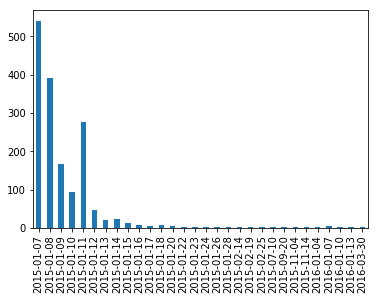

In [68]:
plot_frequency_tags(df_tag, 'day', "#jesuischarlie", 30)

In [71]:
def compute_unique_tag_list_and_store():
    """Compute the list of different hashtags"""
    
    concat_list = np.concatenate(df_tag.tag.apply(lambda x : np.array(get_hashtags(x))))
    unique_tags = np.unique(concat_list)
    with open('../../twitter_dataset/unique_hashtags.json', 'w') as outfile:
        json.dump(unique_tags.tolist(), outfile)
    
def load_unique_tag_list():
    with open('../../twitter_dataset/unique_hashtags.json', 'r') as infile:
        unique_tags = json.load(infile)
    return unique_tags


In [72]:
def get_index_with_hashtag(df, hashtag):
    """Returns the indices of the tweets in which the given hashtag appears."""
    
    return np.where(df.tag.apply(lambda x : ("'"+hashtag+"'") in x.lower()))

def group_by_hashtag(df, load_hashtags_list=True):
    """For each hashtag, give the indices of the tweets in which it appears.
    
    df: dataframe to use for the grouping
    load_hashtags_list: if True, loads the list of different hashtags from a file saved previously.
                        if False, computes the hashtag list again.
    """
    
    if load_hashtags_list:
        # Load hashtag list from file
        unique_tags = load_hashtag_list()  
    else:
        # Compute hashtag list
        unique_tags = compute_hashtag_list(df)  

    # Get the indices of the tweets in which each hashtag appears
    output = {}
    for hashtag in unique_tags:
        output[hashtag] = get_index_with_hashtag(df, hashtag)
        
    # Convert to dataframe
    output_df = pd.DataFrame.from_dict(output, orient='index')
    output_df.reset_index(inplace=True)
    output_df.columns = ['hashtag', 'tweets_idx']
    return output_df

In [76]:
def get_index_with_hashtag(df, hashtag):
    return np.where(df.tag.apply(lambda x : ("'"+hashtag+"'") in x))

def group_by_hashtag(df):
    unique_tags = load_unique_tag_list()    
    output = {}
    for hashtag in unique_tags:
        output[hashtag] = get_index_with_hashtag(df, hashtag)
    output_df = pd.DataFrame.from_dict(output, orient='index')
    output_df.reset_index(inplace=True)
    output_df.columns = ['hashtag', 'tweets_idx']
    return output_df

group_hashtags = group_by_hashtag(df_tag.head(20))
group_hashtags

12


,hashtag,tweets_idx
0,#0,[]
1,#00,[]
2,#000,[]
3,#0000,[]
4,#000000,[]
5,#00009,[]
6,#0001,[]
7,#000ffff,[]
8,#000webhost,[]
9,#001,[]


In [77]:
group_hashtags_nb = group_hashtags.copy()
group_hashtags_nb['tweets_nb'] = group_hashtags_nb['tweets_idx'].apply(lambda ls: len(ls))
group_hashtags_nb.sort_values('tweets_nb', ascending=False).drop(['tweets_idx'], axis=1).head(15)

,hashtag,tweets_nb
246817,#fb,4
87996,#betterthanwordpress,1
517878,#nichtversteh,1
269975,#frauen,1
366668,#iphone,1
835070,#yam,1
843421,#zhwahlen2010,1
797412,#vfb,1
769877,#tumblr,1
560113,#partnermonth,1


## 2.2. Aggregating by time

# 3. Data Analysis and Visualization